In [3]:
from transformers import pipeline
import pandas as pd
import re
import os

In [4]:
# Load dataset and take only the first 1000 rows
df = pd.read_csv("Generated_Summaries.csv").head(1000)

In [5]:
# Clean the text
def clean_text(text):
    text = re.sub(r'header:\s*', '', str(text), flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'<.*?>', '', text)
    return text[:1000]  # Truncate to 1000 characters to avoid token limit

In [6]:
# Drop rows with missing values in required columns
df = df.dropna(subset=['text', 'article_summaries'])

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

In [7]:
# Load BART summarizer
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", framework="pt")

Device set to use cpu


In [8]:
# Generate summaries for first 10 rows
df['bart_summary'] = df['clean_text'].head(10).apply(
    lambda text: summarizer(text, max_length=60, min_length=30, do_sample=False)[0]['summary_text']
)

In [9]:
# Show results
print(df[['clean_text', 'article_summaries', 'bart_summary']].head())

                                          clean_text  \
0  Plains Indians Tell Their Stories Through Ledg...   
1  Cancer Compatibility in Love, Work and Friends...   
2  Scorpio Personality: October 23 - November 21:...   
3  Was Humpty Dumpty Really an Egg?: The nursery ...   
4  Christo Was His Name, Wrapping Was His Game: M...   

                                   article_summaries  \
0  Hey there, art lovers! Ever heard of Ledger Ar...   
1  Hey there, star gazers! Ever wondered how your...   
2  Hey there, stargazers! Ever wondered what make...   
3  Hey there, curious minds! Ever wondered about ...   
4  Hey there, art enthusiasts! Ever heard of Chri...   

                                        bart_summary  
0  Ledger art is a form of drawing practiced by P...  
1  If your birthday falls between June 21 and Jul...  
2  Scorpio is the eighth sign of the astrological...  
3  Humpty Dumpty is portrayed as an egg with huma...  
4  Christo Vladimirov Javacheff, known worldwide ..

In [10]:
import evaluate

# Load ROUGE metric
rouge = evaluate.load("rouge")

# Initialize a list to store the ROUGE-1 scores
rouge1_scores = []

# Ensure predictions and references are in list format
for p, r in zip(df['bart_summary'], df['article_summaries']):
    result = rouge.compute(predictions=[str(p)], references=[str(r)])
    rouge1_scores.append(result['rouge1'])  # Directly append the ROUGE-1 score

# Add the ROUGE-1 scores to your DataFrame
df['rouge1'] = rouge1_scores

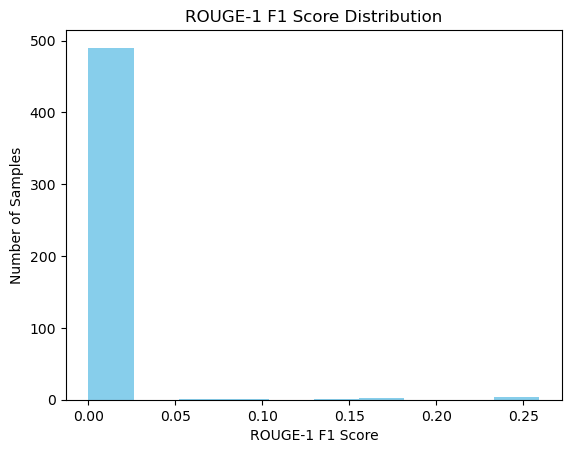

In [11]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(df['rouge1'], bins=10, color='skyblue')
plt.title("ROUGE-1 F1 Score Distribution")
plt.xlabel("ROUGE-1 F1 Score")
plt.ylabel("Number of Samples")
plt.show()

In [12]:
t5_summarizer = pipeline("summarization", model="t5-small")
df['t5_summary'] = df['clean_text'].head(10).apply(
    lambda text: t5_summarizer(text, max_length=60, min_length=30, do_sample=False)[0]['summary_text']
)

Device set to use cpu


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_keywords(text, n=5):
    vec = TfidfVectorizer(stop_words='english')
    tfidf = vec.fit_transform([text])
    indices = tfidf[0].toarray().argsort()[0][-n:]
    keywords = [vec.get_feature_names_out()[i] for i in indices]
    return keywords

df['keywords'] = df['clean_text'].apply(extract_keywords)